# USING RANDOM FORESTS

# Imports and Data

In [22]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from IPython.display import display
from sklearn.tree import export_graphviz
from scipy.stats import binom
import matplotlib.pyplot as plt
from sklearn import tree
import numpy as np

from common.trinary_data import TrinaryData
from common_python import constants as cn
from common_python.classifier.feature_set import FeatureSet

In [39]:
TRINARY = TrinaryData(is_averaged=False, is_dropT1=False, is_regulator=True)  # Trinary data
DF_X = TRINARY.df_X
SER_Y = TRINARY.ser_y
FEATURES = list(DF_X.columns)

In [3]:
SER_Y1 = SER_Y.apply(lambda v: 1 if v==1 else 0)
SER_Y1

T1.0     0
T1.1     0
T1.2     0
T2.0     1
T2.1     1
        ..
T24.1    0
T24.2    0
T25.0    0
T25.1    0
T25.2    0
Name: name, Length: 75, dtype: int64

Note some transformation is required if this is a binary classifier.

# Random Forest Usage

1. The RandomForest classifier creates decision trees that can be obtained from the property ``estimators_``.
1. The relative weighting of features can be found in ``feature_importances_``.
1. An estimator is a DecisionTree. This has the properties:
   1. ``tree_.value``: class splits at that node
   1. ``myTree.tree_.threshold`` is an array of thresholds for spitting values for "<=", such as Rv3911 <= -0.5.
   out-of-range thresholds indicate leaves.

In [4]:
# Bootstrap == False: use all of the samples
clf = RandomForestClassifier(max_depth=4, random_state=0, bootstrap=False,
                            min_impurity_decrease=.01, min_samples_leaf=5)
_ = clf.fit(DF_X, SER_Y1)

# Visualization

In [5]:
binom.cdf(4, 5, 0.5)

0.96875

In [6]:
myTree = clf.estimators_[0]

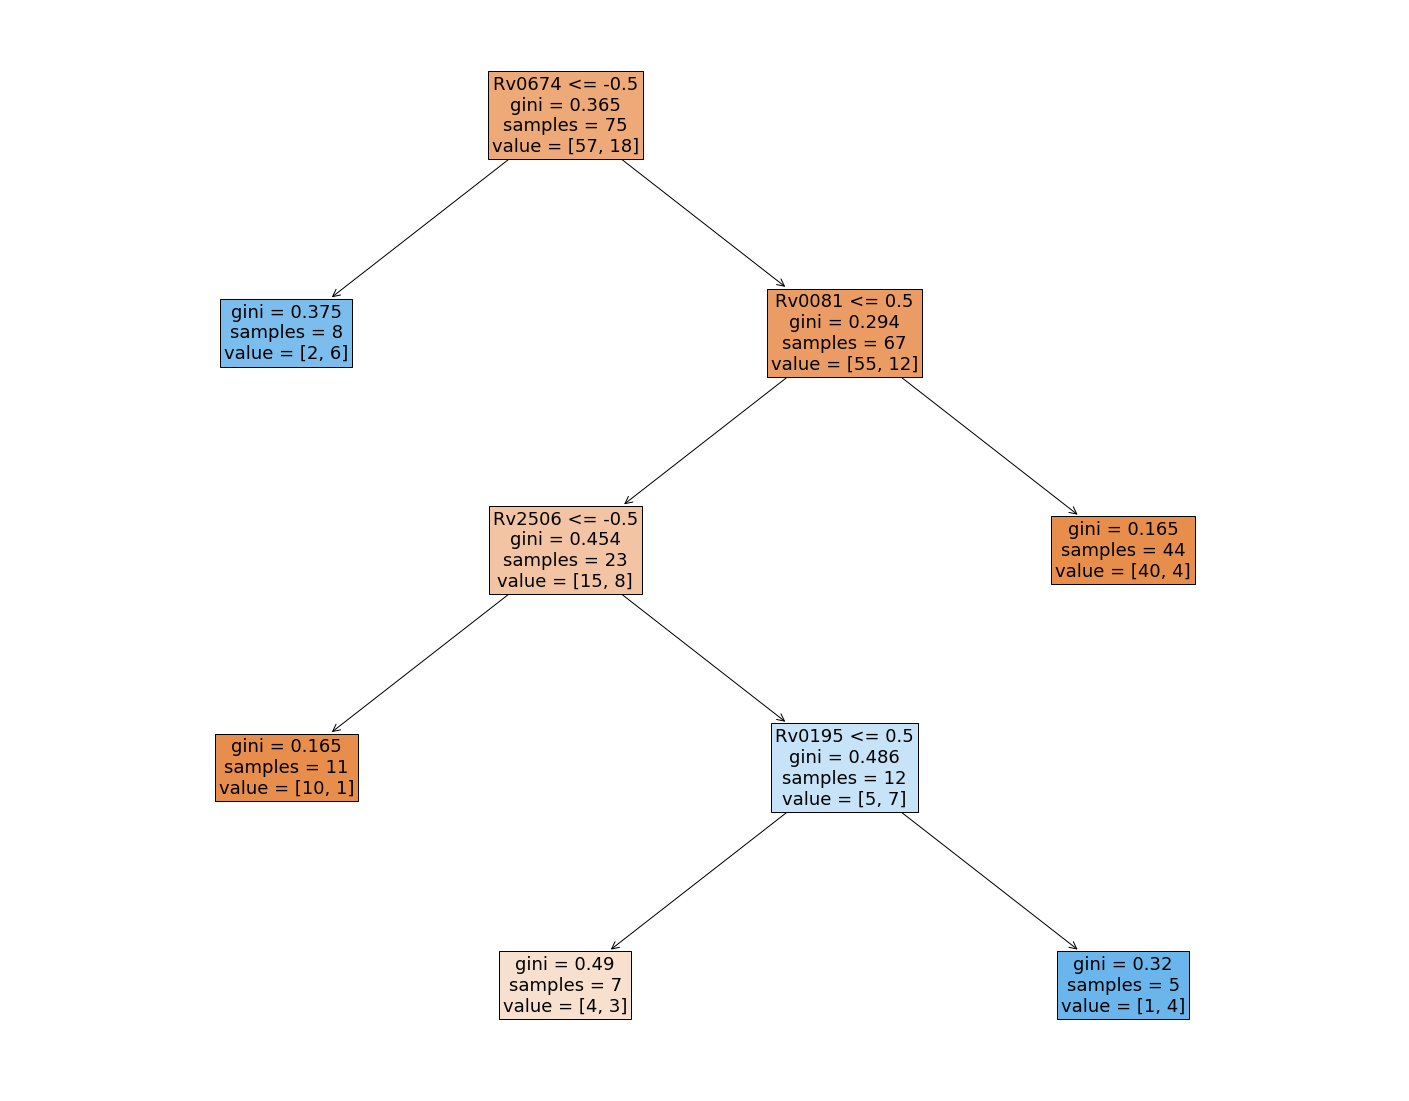

In [50]:
# Creates plots in matplotlib
fig = plt.figure(figsize=(25,20))
# the clf is Decision Tree object
_ = tree.plot_tree(myTree,feature_names=DF_X.columns, fontsize=18['Rv1189', 'Rv3167c', 'Rv1675c', 'Rv2642'],
                   filled=True)


In [ ]:
['Rv3246c', 'Rv2506', 'Rv0081', 'Rv0674']

In [42]:
myTree.tree_.children_left

array([ 1, -1,  3,  4, -1,  6, -1, -1, -1])

In [9]:
myTree.tree_.threshold

array([-0.5, -0.5, -2. , -2. ,  0.5,  0.5, -2. , -2. , -2. ])

In [10]:
# The feature property provides maps from the node index in the tree (position in the array)
# to the node index in the original set of features
myTree.tree_.feature

array([27, 45, -2, -2, 52, 85, -2, -2, -2])

In [11]:
# Position zero has a 45, which is the node index in the original features
list(DF_X.columns)[45]

'Rv3911'


Notes
1. Can find the nodes used via decision path. Will that give me node values?
1. Can find number of samples in a leaf. Use impurity to get split between classes?

In [27]:
sel = [v[0][0] >20 for v in myTree.tree_.value]
myTree.tree_.value[sel]

array([[[57., 18.]],

       [[45.,  8.]],

       [[38.,  3.]],

       [[33.,  1.]]])

In [40]:
FEATURES[myTree.tree_.feature[0]]

'Rv0674'

In [36]:
myTree.tree_.children_left

array([ 1, -1,  3,  4, -1,  6, -1, -1, -1])

In [55]:
def _getFeatures(dtree, dtree_node):
    """ 
    Finds the features in the path to this node in the decision tree.

    Parameters
    ----------
    dtree: DecisionTreeClassifier
    dtree_node: int
        node in the decision tree
    
    Returns
    -------
    FeatureSet
    """
    def getParents(arr, node):
      parents = [n for n in range(len(arr)) if arr[n] == node]
      if len(parents) > 1:
        raise RuntimeError("Cannot have more than one parent in a tree!")
      return parents
    #   
    done = False
    features = dtree.tree_.feature
    node_path = [dtree_node]
    for _ in range(len(dtree.tree_.children_left)):
      last_node = node_path[-1]
      if last_node == 0:
        # Found root
        break
      left_parents = getParents(dtree.tree_.children_left, last_node)
      right_parents = getParents(dtree.tree_.children_right, last_node)
      parents = list(left_parents)
      parents.extend(right_parents)
      if len(parents) != 1:
        raise RuntimeError("Must have a parent!")
      last_node = parents[0]
      node_path.append(last_node)
    #   
    return node_path
[FEATURES[myTree.tree_.feature[v]] for v in _getFeatures(myTree, 3)]

['Rv2506', 'Rv0081', 'Rv0674']

In [12]:
myTree.tree_.value

array([[[57., 18.]],

       [[12., 10.]],

       [[ 5.,  8.]],

       [[ 7.,  2.]],

       [[45.,  8.]],

       [[38.,  3.]],

       [[33.,  1.]],

       [[ 5.,  2.]],

       [[ 7.,  5.]]])

# Programming Notes

## Decision Rules

In [13]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)
    
tree_to_code(myTree, DF_X.columns)

def tree(Rv2642, Rv0022c, Rv1675c, Rv3167c, Rv1189, Rv2488c, Rv1395, Rv0324, Rv3082c, Rv1049, Rv1460, Rv1674c, Rv0767c, Rv3249c, Rv2034, Rv0081, Rv0232, Rv0117, Rv3855, Rv0047c, Rv0067c, Rv2359, Rv1990c, Rv0474, Rv2250c, Rv0330c, Rv3830c, Rv1186c, Rv2506, Rv3066, Rv0623, Rv1773c, Rv0078, Rv0494, Rv1719, Rv3164c, Rv2011c, Rv0602c, Rv2760c, Rv1657, Rv1473A, Rv3183, Rv3833, Rv3405c, Rv2827c, Rv3911, Rv2017, Rv0674, Rv1556, Rv3124, Rv3862c, Rv0880, Rv0195, Rv2009, Rv0827c, Rv0894, Rv0302, Rv0653c, Rv3219, Rv0135c, Rv3416, Rv1219c, Rv1176c, Rv2021c, Rv0967, Rv3095, Rv0158, Rv2779c, Rv0023, Rv0042c, Rv3173c, Rv1846c, Rv2069, Rv0238, Rv3050c, Rv3223c, Rv1404, Rv0445c, Rv1332--Rv1828--Rv0981, Rv1379, Rv3676, Rv2595, Rv1423, Rv1956, Rv3291c, Rv3160c, Rv3849, Rv3557c, Rv2745c, Rv3414c, Rv1359, Rv0891c, Rv3597c, Rv3133c, Rv0353, Rv0054, Rv1994c, Rv3417c, Rv3246c, Rv3260c):
  if Rv1186c <= -0.5:
    if Rv3911 <= -0.5:
      return [[5. 8.]]
    else:  # if Rv3911 > -0.5
      return [[7. 2.]]
  el

In [33]:
myTree = clf.estimators_[20]
myTree.tree_.children_right

array([ 2, -1,  8,  5, -1,  7, -1, -1, -1])

## Finding Leaves

In [14]:
if False:
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

## Feature Values

Feature values are taken from the numpy array supplied to the decision tree.
Columns are features; rows are samples (instances).

# Decision Tree Extractor
Extracts key information from a fitted decision tree:
* Cases (feature set + feature vector)

In [15]:
features = ["Rv3911", "Rv3405c"]
fs = FeatureSet(features)
fs.__dict__

{'intercept': None,
 'coefs': None,
 'set': {'Rv3405c', 'Rv3911'},
 'str': 'Rv3405c+Rv3911',
 '_analyzer': None,
 'list': ['Rv3405c', 'Rv3911']}

In [16]:
class Case(object):
    
    def __init__(self, feature_set, feature_values, count, frac, siglvl):
        """
        
        Parameters
        ----------
        siglvl: float
            Positive - significance level for class 1
            Negative - significance level for class 0
        """
        self.feature_set = feature_set
        self.feature_values = feature_values
        self.count = count
        self.frac = frac
        self.siglvl = siglvl
    
    @classmethod
    def mkCases(cls, features, data):
        """
        Constructs cases for a collection of features.
        Find all instances of the feature values and calculate significance levels.
        
        Returns
        -------
        list-Case
        """
        feature_set = FeatureSet(features)
        df_profile = feature_set.profileTrinary(data=data)
        cases = []
        for feature_values, row in df_profile.iterrows():
            if row[cn.SIGLVL_POS] > row[cn.SIGLVL_NEG]:
                sl = -row[cn.SIGLVL_NEG]
            else:
                sl = row[cn.SIGLVL_POS]
            cases.append(Case(feature_set, feature_values, row[cn.COUNT], row[cn.FRAC], sl))
        #
        return cases
        
# Tests
cases = Case.mkCases([ 'Rv3405c', 'Rv3911'], (DF_X, SER_Y1))

In [17]:
cases[0].__dict__

{'feature_set': Rv3405c+Rv3911,
 'feature_values': (-1, -1),
 'count': 7.0,
 'frac': 0.14285714285714285,
 'siglvl': -0.0625}

In [18]:
[(c.feature_values, c.frac, c.count, c.siglvl) for c in cases]

[((-1, -1), 0.14285714285714285, 7.0, -0.0625),
 ((-1, 0), 0.2857142857142857, 21.0, -0.03917694091796874),
 ((-1, 1), 0.0, 1.0, nan),
 ((0, -1), 0.13333333333333333, 15.0, -0.003692626953124999),
 ((0, 0), 0.2903225806451613, 31.0, -0.014724686741828929),
 ((0, 1), nan, 0.0, nan),
 ((1, -1), nan, 0.0, nan),
 ((1, 0), nan, 0.0, nan),
 ((1, 1), nan, 0.0, nan)]